# The Abalone Dataset
The dataset presented in this project is taken from the <a href="http://archive.ics.uci.edu/ml/datasets/Abalone">Abalone Data Set</a> from UC Irvine Machine Learning Repository. The data contains information about the abalone's physical features, including the sex/gender, length of shell, diameter (perpendicular to length), height, overall weight, rings, etc.

The problem to be solved for this project is to build and train a system that can predict the age of an abalone from the physical features. It can be shaped as a classification problem, in which the model will try to classify the abalone into a class of age group (i.e. age under 8, age between 8 and 11, or age above 11, etc.). It can also be a regression problem, in which the model will try to predict the exact age of the abalone.

This project tries to solve the problem using a multi-class classifier and a regressor, each with an initial attempt and a second attempt after reshaping the prediction problem.

In [1]:
import numpy as np
import pandas as pd
from pandas import get_dummies

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, f1_score
from sklearn import datasets, linear_model

---
## Data Understanding and Exploration

In [3]:
colnames=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'] 
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

df = pd.read_csv(url, names=colnames, header=None)

In [4]:
df.head(3)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


In [5]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


The *'rings'* column can be seen as an indicator for the age of abalone. The integer value in the 'ring' colum plus 1.5 will give the age in years.

#### Check for Missing Values

In [6]:
# Check if any missing values
df.isnull().values.any()

False

We can observe that there is no missing value in this dataset.

#### Visual Representation of Numeric Features

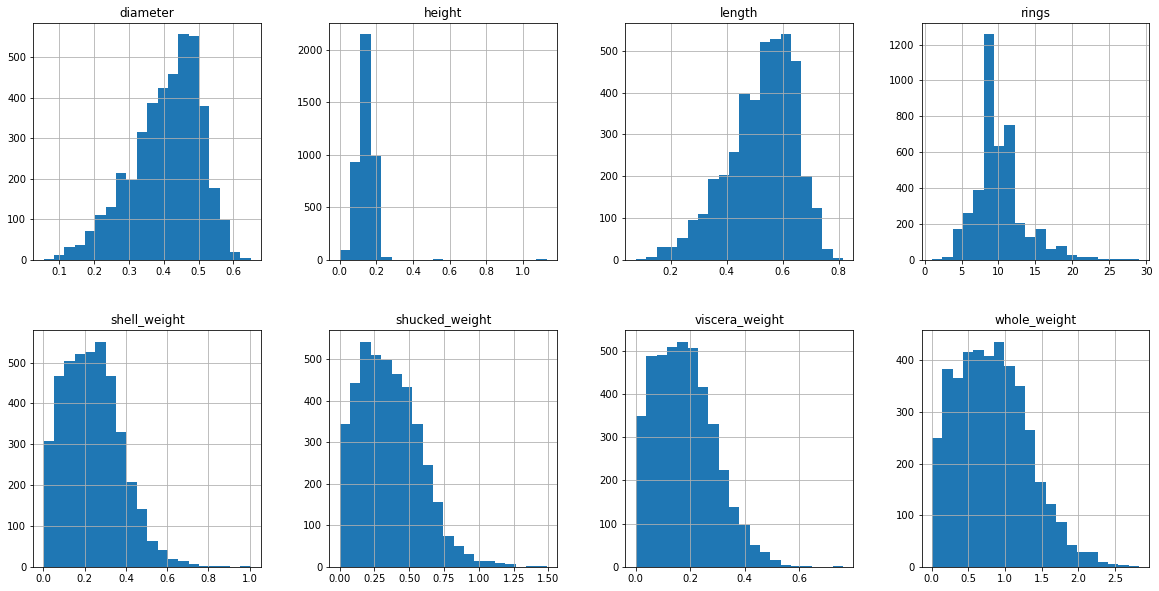

In [7]:
# Plot numeric features in histograms
df.hist(figsize=(20,10), grid=True, layout=(2,4), bins=20);

From this visual representation of the dataset, we can see that the numeric features are skewed.

#### Understanding the Target Feature
Let's look at the details for our target/predicting feature -- the 'rings' column.

In [8]:
df['rings'].nunique()

28

In [9]:
df.rings.value_counts()

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
24      2
27      2
1       1
25      1
2       1
26      1
29      1
Name: rings, dtype: int64

In [10]:
df.rings.value_counts(normalize=True)

9     0.164951
10    0.151784
8     0.135983
11    0.116591
7     0.093608
12    0.063921
6     0.062006
13    0.048599
14    0.030165
5     0.027532
15    0.024659
16    0.016040
17    0.013886
4     0.013646
18    0.010055
19    0.007661
20    0.006225
3     0.003591
21    0.003352
23    0.002155
22    0.001436
24    0.000479
27    0.000479
1     0.000239
25    0.000239
2     0.000239
26    0.000239
29    0.000239
Name: rings, dtype: float64

From the analysis above, we can observe that **certain classes in the 'rings' column have very low percentage of showing up** in the datasets, meaning that **they are outliers**. This may be a concern if we want our classifiers or regressor to predict accurately.

---
## Preprocessing the Data

#### Adding 'Age' Column
As stated in the data description, the age can be calculated by adding 1.5 to the values in the 'rings' column.

In [11]:
# Insert 'age' column based on the values from the 'rings' column
df['age'] = df.apply(lambda row: row.rings + 1.5, axis = 1) 

#### One-Hot Encoding Nominal/Numeric Feature

In [12]:
# Select features by type (numeric vs. nominal/catergorical)
num_attrib = df.select_dtypes(include=[np.number]).columns
cat_attrib = df.select_dtypes(include=[np.object]).columns

In [13]:
num_attrib

Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings', 'age'],
      dtype='object')

In [14]:
cat_attrib

Index(['sex'], dtype='object')

In [15]:
df['sex'].nunique()

3

The *'sex/gender'* column is the only nominal feature in this dataset, with 3 unique values (M, F, and I). It requires some preprocessing--for example, one-hot encoding--before we use it for our regressor.

In [16]:
# One-hot encoding from the 'sex' column
df_sex_1hot = pd.get_dummies(df['sex'])
df_sex_1hot.head(3)

,F,I,M
0,0,0,1
1,0,0,1
2,1,0,0


In [17]:
# Merge one-hot encoded dataframe into original dataframe
df = pd.merge(df, df_sex_1hot, left_index=True, right_index=True)

In [18]:
df.head(3)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,F,I,M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,16.5,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,8.5,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9,10.5,1,0,0


---
## Training the Model - Logistic Regression

### Initial Attempt - Predict Exact Age X

In [19]:
# Selec learning features and target/predicting feature
X = df.drop(['sex', 'rings', 'age'], axis=1)
y = df['rings']

In [20]:
# Split 80% of the data for training and leave out 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [23]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)

Train MSE:  7.674947620472913
Test MSE:  7.8624401913875595


In [24]:
accuracy_score(y_test, y_test_pred)

0.26913875598086123

We can see that the performance of our simple logistic regession model is very poor in classifying data into the exact age class. The accuracy of predictions is very low, with only 0.2691, and the MSE are very high.

*Note: Accuracy score is not a good measure for the performance of a model, but it's being used here for a quick glance instead of a detailed review.*

I think this is a good indication that we should consider reshaping the problem for our logistic regression model from "predicting the exact age" to "whether the age is above or below X". That it, we'll try to **rephrase the problem from a multi-class classification problem to a binary classification problem**. For the X, **10** appears to be a good threshold value, as we can observe **the mean value for the 'rings' column is at 9.93** in our data exploration process.

### Second Attempt - Predict Age > 10 or < 10

In [25]:
# Add a new column for rings > 10 or not
df['rings>10'] = np.where(df['rings'] >= 10, 1, 0)
df[['rings', 'rings>10']].head()

,rings,rings>10
0,15,1
1,7,0
2,9,0
3,10,1
4,7,0


In [26]:
# Selec learning features and target/predicting feature
X = df.drop(['sex', 'rings', 'age', 'rings>10'], axis=1)
y = df['rings>10']

In [27]:
# Split 80% of the data for training and leave out 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

In [29]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [30]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)

Train MSE:  0.2301706076025142
Test MSE:  0.21411483253588517


In [31]:
accuracy_score(y_test, y_test_pred)

0.7858851674641149

In [32]:
f1_score(y_test, y_test_pred)

0.7901524032825322

By reshaping the problem into a binary classification problem, the logistic regression model is able to more accurately predict if the age of the abalone is above or under 10. The accuracy score has improved from high-30's to high-70's, and the MSE is now much lower.

---
## Training the Model - Gradient Boosted Trees

### Initial Attempt - Predict Exact Age X

In [33]:
# Selec learning features and target/predicting feature
X = df.drop(['sex', 'rings', 'age'], axis=1)
y = df['rings']

In [34]:
# Split 80% of the data for training and leave out 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
gbr = GradientBoostingRegressor()

param_grid = [{
    'n_estimators' : [100, 300, 500],
    'max_depth' : [3, 6]
}]

# Use grid search to find the best combination of hyperparameters on the given dataset
grid_search = GridSearchCV(gbr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train);

In [36]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [37]:
grid_search.best_estimator_

GradientBoostingRegressor()

In [38]:
best_gbr_model = grid_search.best_estimator_
best_gbr_model.fit(X_train, y_train);

In [39]:
y_train_pred = best_gbr_model.predict(X_train)
y_test_pred = best_gbr_model.predict(X_test)

In [40]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)

Train MSE:  2.295718366237315
Test MSE:  3.6560737647166826


In [41]:
r2_score(y_test, y_test_pred)

0.6622630185160188

The model seem to do poorly on their predictions, scoring low on R-squared and having high mean squared error.

Again, we should consider reshaping the problem. For this time, I'm also refering to the dataset details and will use the 25% and 75% as the mark to seperate the classes. This will seperate the truth into 3 groups: class 1 with rings under 8, class 2 with rings between 8 and 11, and class 3 with rings above 11.

### Second Attempt - Predict Age Group 1, 2, and 3

In [42]:
df_copy = df.copy()

In [43]:
# Add new columns for each of the 3 new age groups
df_copy['rings_1'] = np.where(df['rings'] <= 8, 1, 0)
df_copy['rings_2'] = np.where(((df['rings'] > 8) & (df['rings'] < 11)), 2, 0)
df_copy['rings_3'] = np.where(df['rings'] >= 11, 3, 0)

df_copy[['rings', 'rings_1', 'rings_2', 'rings_3']].head()

,rings,rings_1,rings_2,rings_3
0,15,0,0,3
1,7,1,0,0
2,9,0,2,0
3,10,0,2,0
4,7,1,0,0


In [44]:
# Merge the three columns into one
df_copy['new_rings'] = df_copy['rings_1'] + df_copy['rings_2'] + df_copy['rings_3']
df_copy[['rings', 'new_rings']].head(5)

,rings,new_rings
0,15,3
1,7,1
2,9,2
3,10,2
4,7,1


In [45]:
# Selec learning features and target/predicting feature
X = df_copy.drop(['sex', 'rings', 'age', 'rings>10', 'rings_1', 'rings_2', 'rings_3'], axis=1)
y = df_copy['new_rings']

In [46]:
# Split 80% of the data for training and leave out 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
gbr = GradientBoostingRegressor()

param_grid = [{
    'n_estimators' : [100, 300, 500],
    'max_depth' : [3, 6]
}]

# Use grid search to find the best combination of hyperparameters on the given dataset
grid_search = GridSearchCV(gbr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train);

In [48]:
grid_search.best_params_

{'max_depth': 6, 'n_estimators': 500}

In [49]:
best_gbr_model = grid_search.best_estimator_
best_gbr_model.fit(X_train, y_train);

In [50]:
y_train_pred = best_gbr_model.predict(X_train)
y_test_pred = best_gbr_model.predict(X_test)

In [51]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)

Train MSE:  2.3629376871612845e-30
Test MSE:  2.3794984257589835e-30


In [52]:
r2_score(y_test, y_test_pred)

1.0

After reshaping the problem with less number of classes, the performance of the gradient boosted regressor is really great, with almost 0 in MSE and a 1 in R-squared score.